# INSTALL AND IMPORT PACKAGES

In [ ]:
# Install numpy first to avoid ABI mismatches
!pip install -q numpy==1.26.4

# Reinstall other core packages safely
!pip install -q scipy
!pip install -q gensim
!pip install -q pyldavis
!pip install -q pymupdf
!pip install PyPDF2 -q

# Install compatible torch + torchvision (CPU version to avoid CUDA mismatches)
!pip install -q torch==2.2.2 torchvision==0.17.2 --index-url https://download.pytorch.org/whl/cpu

# Install BERTopic stack
!pip install -q transformers==4.40.2 accelerate==0.27.2 sentence-transformers==2.5.1
!pip install -q bertopic==0.16.4

# Force a runtime restart (Google Colab will auto-reconnect)
import os
os._exit(0)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 78.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━

Necessary libraries and packages are imported here

In [1]:
import pandas as pd
import numpy as np
import json
import gdown
import os
import logging
import re
from typing import Dict, List, Optional, Tuple, Any
from pathlib import Path
import PyPDF2
from dataclasses import dataclass, asdict
from datetime import datetime
import time
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# IMPORT AGENT 3 INPUT AND OUTPUT DATA

In [2]:
def convert_drive_view_to_gdown(view_link: str) -> str:
    """
    Convert a Google Drive 'view' link to a gdown-compatible download link.

    Parameters:
        view_link (str): The full Google Drive view link.

    Returns:
        str: gdown-compatible direct download link, or raises ValueError if invalid.
    """
    match = re.search(r"/d/([a-zA-Z0-9_-]+)", view_link)
    if not match:
        raise ValueError("Invalid Google Drive view link format.")
    file_id = match.group(1)
    return f"https://drive.google.com/uc?id={file_id}"

In [3]:
google_link = 'https://drive.google.com/file/d/1N8UVXBWPqgO0aC0xU0uixMJS80zm4vRV/view?usp=drive_link'

In [4]:
gdrive_url = convert_drive_view_to_gdown(google_link)

gdown.download(gdrive_url, 'Input_Output_Data.csv', quiet=False)

temp_df = pd.read_csv('Input_Output_Data.csv')

temp_df = temp_df[(temp_df['thread_type']=='qa_exchange') & (temp_df['document_type']=='transcript')]

Downloading...
From: https://drive.google.com/uc?id=1N8UVXBWPqgO0aC0xU0uixMJS80zm4vRV
To: /content/Input_Output_Data.csv
100%|██████████| 160k/160k [00:00<00:00, 76.8MB/s]


**Input vs Output Data Structure:**

This block splits the dataframe into two parts:

- `input_data`: metadata and raw conversation for each thread. These columns describe the context, participants, and structure of the earnings call conversation. This is what the LLM (Agent 3) originally received as input.

- `output_data`: all remaining columns, which contain the structured JSON-style outputs generated by Agent 3. Each row contains 50+ flattened metrics across regulatory, conversational, and linguistic domains.

This split allows us to reconstruct the original input/output pair for each thread and pass them to the meta-evaluation framework.


In [5]:
input_columns = ['earnings_id', 'bank_id', 'quarter_year', 'document_type', 'thread_id',
       'thread_type', 'full_conversation_text', 'conversation_length',
       'participants_json', 'primary_executive', 'primary_analyst',
       'question_count', 'follow_up_count', 'source_segments_json']
input_data = temp_df[input_columns].iloc[:25]
output_data = temp_df.drop(columns=input_columns).iloc[:25]

In [6]:
input_data.head()

,earnings_id,bank_id,quarter_year,document_type,thread_id,thread_type,full_conversation_text,conversation_length,participants_json,primary_executive,primary_analyst,question_count,follow_up_count,source_segments_json
3,HSBC_Q1_2023,HSBC,Q1_2023,transcript,thread_qa_001,qa_exchange,"Good morning, gentlemen. Congrats on a good se...",1034,"[{""name"": ""Joseph Dickerson"", ""title"": ""Analys...",Georges Elhedery,Joseph Dickerson,1,0,"[""tr_seg_004"", ""tr_seg_005""]"
4,HSBC_Q1_2023,HSBC,Q1_2023,transcript,thread_qa_002,qa_exchange,"Good morning, gents. Thanks very much for taki...",4095,"[{""name"": ""Raul Sinha"", ""title"": ""Analyst"", ""r...",Georges Elhedery,Raul Sinha,1,1,"[""tr_seg_006"", ""tr_seg_007"", ""tr_seg_008""]"
5,HSBC_Q1_2023,HSBC,Q1_2023,transcript,thread_qa_003,qa_exchange,Good morning. Thanks for taking the questions....,3339,"[{""name"": ""Manus Costello"", ""title"": ""Analyst""...",Noel Quinn,Manus Costello,1,1,"[""tr_seg_009"", ""tr_seg_010"", ""tr_seg_011""]"
6,HSBC_Q1_2023,HSBC,Q1_2023,transcript,thread_qa_004,qa_exchange,Good morning everyone. Thanks for taking the q...,1545,"[{""name"": ""Omar Keenan"", ""title"": ""Analyst"", ""...",Georges Elhedery,Omar Keenan,1,0,"[""tr_seg_012"", ""tr_seg_013""]"
7,HSBC_Q1_2023,HSBC,Q1_2023,transcript,thread_qa_005,qa_exchange,I've got two questions. The first one is obvio...,3904,"[{""name"": ""Perlie Mong"", ""title"": ""Analyst"", ""...",Noel Quinn,Perlie Mong,1,0,"[""tr_seg_014"", ""tr_seg_015"", ""tr_seg_016"", ""tr..."


# PROMPTS FROM ORIGINAL CODE

This class provides regulatory context for analyzing financial threads using Bank of England (PRA) priorities.

It does three things:
1. Stores 2025 PRA supervisory priorities.
2. Classifies each thread (e.g. Q&A, executive statement, factual content) based on metadata or speaker roles.
3. Returns a structured prompt with relevant regulatory focus and warning signals, tailored to the thread type.

It enables AI models to analyze transcripts in a way that reflects real-world supervisory concerns.


In [7]:
class EnhancedPRADocumentationManager:
    """Dynamic regulatory context management for thread-based analysis"""
    def __init__(self):
        self.pra_priorities_2025 = """
PRA 2025 SUPERVISORY PRIORITIES:
Risk management, governance and controls:
- Robust governance, risk management and controls frameworks
- Counterparty credit risk (CCR) management focus
- Risk culture assessment and senior management accountability
Data risk:
- Firms need to improve data aggregation for holistic risk management
- Accurate and timely regulatory returns submission
- Data quality for AI and technological developments
Financial resilience:
- Assessment of firms' capital and liquidity with stress testing
- Funding and liquidity landscape changes including ILTR facility
- Capital planning and forward-looking indicators
Operational resilience:
- Remain within impact tolerances for important business services
- Cyber threats and third-party risk management
- Legacy infrastructure remediation and resilient IT investments
"""

        self.thread_type_contexts = {
            "qa_exchange": {
                "focus": "Conversational dynamics, information asymmetries, deflection patterns",
                "warning_signals": ["evasive answers", "sentiment divergence", "repeated questioning"],
                "regulatory_lens": "Are there concerning communication dynamics between management and analysts?"
            },
            "executive_statement": {
                "focus": "Strategic messaging, forward guidance accuracy, governance tone",
                "warning_signals": ["inconsistent messaging", "defensive language", "vague commitments"],
                "regulatory_lens": "Does management demonstrate clear regulatory awareness and transparency?"
            },
            "document_content": {
                "focus": "Factual accuracy, disclosure completeness, regulatory compliance",
                "warning_signals": ["metric inconsistencies", "disclosure gaps", "compliance concerns"],
                "regulatory_lens": "Are disclosures complete, accurate, and compliant?"
            }
        }

    def detect_thread_type(self, thread_data: Dict) -> str:
        """Intelligent thread type detection from thread metadata"""
        thread_type = thread_data.get('thread_type', 'unknown')

        # Validate thread type
        if thread_type in self.thread_type_contexts:
            return thread_type

        # Fallback detection logic
        doc_type = thread_data.get('document_type', 'unknown')
        participants = thread_data.get('participants_json', '[]')

        try:
            participants_list = json.loads(participants) if participants else []
            roles = [p.get('role', '') for p in participants_list]

            if 'analyst' in roles and 'executive' in roles:
                return "qa_exchange"
            elif 'executive' in roles and doc_type == 'transcript':
                return "executive_statement"
            else:
                return "document_content"
        except:
            return "document_content"

    def get_targeted_regulatory_context(self, thread_data: Dict, detected_thread_type: str) -> str:
        """Generate targeted regulatory context for thread analysis"""
        thread_context = self.thread_type_contexts.get(detected_thread_type,
                                                      self.thread_type_contexts["document_content"])

        return f"""
BANK OF ENGLAND PRA REGULATORY ANALYSIS CONTEXT:
{self.pra_priorities_2025}

THREAD-SPECIFIC ANALYSIS FOCUS:
Analysis Type: {detected_thread_type}
Primary Focus: {thread_context['focus']}
Key Warning Signals: {thread_context['warning_signals']}
Regulatory Lens: {thread_context['regulatory_lens']}

CONVERSATIONAL REGULATORY INTELLIGENCE FRAMEWORK:
You are analyzing as a Bank of England PRA supervisor focusing on:
1. Complete conversational context and dynamics
2. Which of the 4 supervisory priority areas this thread relates to most strongly
3. Sentiment from REGULATORY COMPLIANCE perspective across the entire conversation
4. Communication patterns matching historical enforcement cases
5. Q&A dynamics revealing information asymmetries and deflection patterns
6. Evidence synthesis across conversation flow
7. Single authoritative regulatory assessment for the complete thread
"""

This function generates a detailed prompt for analyzing Q&A threads between analysts and executives.

It uses the EnhancedPRADocumentationManager to:
- Provide PRA regulatory context specific to Q&A exchanges
- Include metadata like speaker names and number of questions
- Instruct the AI to return structured JSON with regulatory insights, sentiment scores, and conversational analysis

The prompt is designed for use with large language models and enforces a strict output format for consistent downstream evaluation.


In [8]:
def qa_prompt(thread_data: Dict):

  conversation = thread_data.get('full_conversation_text', '')
  primary_executive = thread_data.get('primary_executive', 'Unknown Executive')
  primary_analyst = thread_data.get('primary_analyst', 'Unknown Analyst')
  question_count = thread_data.get('question_count', 0)

  targeted_context = EnhancedPRADocumentationManager().get_targeted_regulatory_context(thread_data, 'qa_exchange')


  return f"""
{targeted_context}

CONVERSATIONAL Q&A THREAD REGULATORY ANALYSIS

COMPLETE CONVERSATION THREAD:
Participants: {primary_analyst} (Analyst) → {primary_executive} (Executive)
Questions in thread: {question_count}
Thread Type: Q&A Exchange

CRITICAL ANALYSIS FOCUS:
1. Information asymmetry: Question specificity vs answer directness
2. Deflection progression: How evasion patterns evolve across follow-ups
3. Management defensiveness: Defensive language escalation patterns
4. Regulatory intelligence: BoE priority concerns revealed through complete exchange
5. Conversational dynamics: Power dynamics, interruptions, topic control
6. Assess historical precedent situations and enforcement. Always do this looking backwards from quarter/year being analysed : Evidence synthesis

ENHANCED Q&A ANALYSIS REQUIREMENTS:
- Analyze complete conversation flow, not individual statements
- Detect question deflection and regulatory evasion patterns
- Assess management credibility through response quality
- Identify information asymmetries between management knowledge and market concerns
- Map conversation to specific BoE supervisory priorities

RETURN ONLY VALID JSON in this exact format:
{{
  "boe_priority_analysis": {{
    "governance_controls": {{
      "sentiment": 0.2,
      "confidence": 0.9,
      "relevance": 0.8,
      "key_topics": ["board oversight", "risk culture"],
      "pra_policy_refs": ["SS5/21"],
      "warning_signals": ["weak controls language"]
    }},
    "data_risk": {{
      "sentiment": 0.0,
      "confidence": 0.7,
      "relevance": 0.3,
      "key_topics": ["data quality"],
      "pra_policy_refs": ["data governance"],
      "warning_signals": []
    }},
    "financial_resilience": {{
      "sentiment": 0.1,
      "confidence": 0.8,
      "relevance": 0.9,
      "key_topics": ["capital planning"],
      "pra_policy_refs": ["Basel 3.1"],
      "warning_signals": ["capital concerns"]
    }},
    "operational_resilience": {{
      "sentiment": -0.2,
      "confidence": 0.9,
      "relevance": 0.6,
      "key_topics": ["cyber risk"],
      "pra_policy_refs": ["operational resilience"],
      "warning_signals": ["operational incidents"]
    }}
  }},
  "qa_dynamics_analysis": {{
    "qa_sentiment_divergence": 0.6,
    "qa_deflection_score": 0.4,
    "qa_regulatory_tension": 0.5,
    "qa_analyst_persistence": 0.7,
    "qa_management_defensiveness": 0.3,
    "qa_information_asymmetry": 0.8
  }},
  "conversational_intelligence": {{
    "conversation_quality_assessment": "concerning",
    "management_credibility_score": 0.4,
    "information_flow_analysis": "restricted",
    "deflection_progression_score": 0.6,
    "analyst_persistence_intensity": 0.8
  }},
  "unified_regulatory_assessment": {{
    "primary_regulatory_concern": "financial_resilience",
    "concern_confidence_score": 0.85,
    "regulatory_urgency_level": "elevated",
    "enforcement_probability": 0.3
  }},
  "evidence_synthesis": {{
    "thread_evidence_strength": 0.7,
    "conversation_evidence_strength": 0.8,
    "historical_pattern_match": 0.6,
    "cross_validation_score": 0.8
  }},
  "regulatory_intelligence": {{
    "overall_sentiment": 0.1,
    "regulatory_concern_level": "medium",
    "enforcement_risk_score": 0.3,
    "market_vs_regulatory_sentiment": 0.4,
    "primary_boe_priority": "financial_resilience",
    "secondary_boe_priority": "operational_resilience",
    "regulatory_topic_category": "capital"
  }},
  "linguistic_analysis": {{
    "uncertainty_score": 0.6,
    "future_focus_score": 0.5,
    "defensive_language_score": 0.4,
    "confidence_language_score": 0.4,
    "hedge_words_count": 12,
    "forward_statements_count": 2,
    "regulatory_keywords_count": 8
  }},
  "enforcement_analysis": {{
    "enforcement_risk_indicators": ["deflection patterns", "information asymmetry"],
    "historical_pattern_matches": ["Credit Suisse Q2 2021"],
    "pra_workflow_recommendation": "Enhanced Q&A monitoring in next PSM",
    "regulatory_timeline_urgency": "within_90_days"
  }},
  "analysis_metadata": {{
    "thread_type": "qa_exchange",
    "analysis_confidence_overall": 0.85,
    "validation_flags": ["complete_conversation_analysis"],
    "token_usage": 450
  }}
}}

CONVERSATION TO ANALYZE:
{conversation}

Return ONLY the JSON object above.
"""

# OUTPUT REORGANIZATION

A list of all the output variables is printed below

In [9]:
output_data.columns.to_list()

['analysis_priority',
 'governance_sentiment',
 'governance_confidence',
 'governance_relevance',
 'governance_topics_json',
 'governance_pra_refs_json',
 'data_risk_sentiment',
 'data_risk_confidence',
 'data_risk_relevance',
 'data_risk_topics_json',
 'data_risk_pra_refs_json',
 'financial_resilience_sentiment',
 'financial_resilience_confidence',
 'financial_resilience_relevance',
 'financial_resilience_topics_json',
 'financial_resilience_pra_refs_json',
 'operational_resilience_sentiment',
 'operational_resilience_confidence',
 'operational_resilience_relevance',
 'operational_resilience_topics_json',
 'operational_resilience_pra_refs_json',
 'overall_sentiment',
 'regulatory_concern_level',
 'enforcement_risk_score',
 'market_vs_regulatory_sentiment',
 'uncertainty_score',
 'future_focus_score',
 'defensive_language_score',
 'confidence_language_score',
 'hedge_words_count',
 'forward_statements_count',
 'regulatory_keywords_count',
 'primary_boe_priority',
 'secondary_boe_priori

Non-financial metrics are discarded

In [10]:
metrics_tobeanalysed = [metric for metric in output_data.columns.to_list() if metric not in ['token_usage','agent_version','claude_model_version','processing_timestamp','validation_flags_json']]
metrics_list = "\n".join(f"- {line}" for line in metrics_tobeanalysed)
print(metrics_list)
print('Number of metrics to be analysed is', len(metrics_tobeanalysed))

- analysis_priority
- governance_sentiment
- governance_confidence
- governance_relevance
- governance_topics_json
- governance_pra_refs_json
- data_risk_sentiment
- data_risk_confidence
- data_risk_relevance
- data_risk_topics_json
- data_risk_pra_refs_json
- financial_resilience_sentiment
- financial_resilience_confidence
- financial_resilience_relevance
- financial_resilience_topics_json
- financial_resilience_pra_refs_json
- operational_resilience_sentiment
- operational_resilience_confidence
- operational_resilience_relevance
- operational_resilience_topics_json
- operational_resilience_pra_refs_json
- overall_sentiment
- regulatory_concern_level
- enforcement_risk_score
- market_vs_regulatory_sentiment
- uncertainty_score
- future_focus_score
- defensive_language_score
- confidence_language_score
- hedge_words_count
- forward_statements_count
- regulatory_keywords_count
- primary_boe_priority
- secondary_boe_priority
- regulatory_topic_category
- enforcement_risk_indicators_json


# META-PROMPT CREATION

This function takes a single row from a dataframe (as a Python dictionary) and formats it into a structured JSON output that matches the schema expected from the LLM agent.

**Purpose:**

It is used to **reconstruct or simulate** the output JSON structure that would be generated by Agent 3. This is helpful when you:
- Load data from a `.csv` file
- Want to reformat rows into the original nested structure for evaluation or re-use

**Key Details:**

- Each top-level section (e.g. `boe_priority_analysis`, `qa_dynamics_analysis`, etc.) corresponds to a part of the LLM output schema.
- The function extracts values from the row using `.get()`, with default fallbacks (e.g., 0.0 for floats or empty lists).
- Some fields (like topics, policy refs, indicators) are stored as JSON strings in the CSV and are decoded with `json.loads()`.
- The result is returned as a formatted JSON string using `json.dumps(..., indent=2)`.

This function makes it easy to reconstruct complete analysis outputs from tabular evaluation data, enabling visual inspection, re-analysis, or prompt testing.


In [11]:
import json

def format_output_json_from_row(row_dict: dict) -> str:
    output = {
        "boe_priority_analysis": {
            "governance_controls": {
                "sentiment": row_dict.get("governance_sentiment", 0.0),
                "confidence": row_dict.get("governance_confidence", 0.0),
                "relevance": row_dict.get("governance_relevance", 0.0),
                "key_topics": json.loads(row_dict.get("governance_topics_json", "[]")),
                "pra_policy_refs": json.loads(row_dict.get("governance_pra_refs_json", "[]")),
                "warning_signals": []
            },
            "data_risk": {
                "sentiment": row_dict.get("data_risk_sentiment", 0.0),
                "confidence": row_dict.get("data_risk_confidence", 0.0),
                "relevance": row_dict.get("data_risk_relevance", 0.0),
                "key_topics": json.loads(row_dict.get("data_risk_topics_json", "[]")),
                "pra_policy_refs": json.loads(row_dict.get("data_risk_pra_refs_json", "[]")),
                "warning_signals": []
            },
            "financial_resilience": {
                "sentiment": row_dict.get("financial_resilience_sentiment", 0.0),
                "confidence": row_dict.get("financial_resilience_confidence", 0.0),
                "relevance": row_dict.get("financial_resilience_relevance", 0.0),
                "key_topics": json.loads(row_dict.get("financial_resilience_topics_json", "[]")),
                "pra_policy_refs": json.loads(row_dict.get("financial_resilience_pra_refs_json", "[]")),
                "warning_signals": []
            },
            "operational_resilience": {
                "sentiment": row_dict.get("operational_resilience_sentiment", 0.0),
                "confidence": row_dict.get("operational_resilience_confidence", 0.0),
                "relevance": row_dict.get("operational_resilience_relevance", 0.0),
                "key_topics": json.loads(row_dict.get("operational_resilience_topics_json", "[]")),
                "pra_policy_refs": json.loads(row_dict.get("operational_resilience_pra_refs_json", "[]")),
                "warning_signals": []
            }
        },
        "qa_dynamics_analysis": {
            "qa_sentiment_divergence": row_dict.get("qa_sentiment_divergence", 0.0),
            "qa_deflection_score": row_dict.get("qa_deflection_score", 0.0),
            "qa_regulatory_tension": row_dict.get("qa_regulatory_tension", 0.0),
            "qa_analyst_persistence": row_dict.get("qa_analyst_persistence", 0.0),
            "qa_management_defensiveness": row_dict.get("qa_management_defensiveness", 0.0),
            "qa_information_asymmetry": row_dict.get("qa_information_asymmetry", 0.0)
        },
        "conversational_intelligence": {
            "conversation_quality_assessment": row_dict.get("conversation_quality_assessment", ""),
            "management_credibility_score": row_dict.get("management_credibility_score", 0.0),
            "information_flow_analysis": row_dict.get("information_flow_analysis", ""),
            "deflection_progression_score": row_dict.get("deflection_progression_score", 0.0),
            "analyst_persistence_intensity": row_dict.get("analyst_persistence_intensity", 0.0)
        },
        "unified_regulatory_assessment": {
            "primary_regulatory_concern": row_dict.get("primary_regulatory_concern", ""),
            "concern_confidence_score": row_dict.get("concern_confidence_score", 0.0),
            "regulatory_urgency_level": row_dict.get("regulatory_urgency_level", "routine"),
            "enforcement_probability": row_dict.get("enforcement_probability", 0.0)
        },
        "evidence_synthesis": {
            "thread_evidence_strength": row_dict.get("thread_evidence_strength", 0.0),
            "conversation_evidence_strength": row_dict.get("conversation_evidence_strength", 0.0),
            "historical_pattern_match": row_dict.get("historical_pattern_match", 0.0),
            "cross_validation_score": row_dict.get("cross_validation_score", 0.0)
        },
        "regulatory_intelligence": {
            "overall_sentiment": row_dict.get("overall_sentiment", 0.0),
            "regulatory_concern_level": row_dict.get("regulatory_concern_level", "low"),
            "enforcement_risk_score": row_dict.get("enforcement_risk_score", 0.0),
            "market_vs_regulatory_sentiment": row_dict.get("market_vs_regulatory_sentiment", 0.0),
            "primary_boe_priority": row_dict.get("primary_boe_priority", ""),
            "secondary_boe_priority": row_dict.get("secondary_boe_priority", ""),
            "regulatory_topic_category": row_dict.get("regulatory_topic_category", "")
        },
        "linguistic_analysis": {
            "uncertainty_score": row_dict.get("uncertainty_score", 0.0),
            "future_focus_score": row_dict.get("future_focus_score", 0.0),
            "defensive_language_score": row_dict.get("defensive_language_score", 0.0),
            "confidence_language_score": row_dict.get("confidence_language_score", 0.0),
            "hedge_words_count": row_dict.get("hedge_words_count", 0),
            "forward_statements_count": row_dict.get("forward_statements_count", 0),
            "regulatory_keywords_count": row_dict.get("regulatory_keywords_count", 0)
        },
        "enforcement_analysis": {
            "enforcement_risk_indicators": json.loads(row_dict.get("enforcement_risk_indicators_json", "[]")),
            "historical_pattern_matches": json.loads(row_dict.get("historical_pattern_matches_json", "[]")),
            "pra_workflow_recommendation": "",  # Can be set if present
            "regulatory_timeline_urgency": row_dict.get("regulatory_urgency_level", "routine")
        },
        "analysis_metadata": {
            "thread_type": row_dict.get("primary_regulatory_concern", ""),  # Replace if another column better fits
            "analysis_confidence_overall": row_dict.get("analysis_confidence_overall", 0.0),
            "validation_flags": json.loads(row_dict.get("validation_flags_json", "[]")),
            "token_usage": row_dict.get("token_usage", 0)
        }
    }

    return json.dumps(output, indent=2)

This function generates a second-order evaluation prompt — in other words, it creates instructions for an AI model to review and critique the outputs of another AI system.

**Purpose:**

It is used to evaluate the **quality and relevance** of a large set of metrics (50+) generated by a language model analyzing a financial conversation. Each metric reflects aspects like regulatory alignment, sentiment, linguistic patterns, or enforcement risk.

**Key Functions:**

1. **Defines the meta-evaluator's role**:  
   The AI is asked to behave like a senior regulatory reviewer, checking whether each metric in the model's output is actually relevant to the context of the conversation and prompt.

2. **Inputs:**
   - `thread_data`: metadata about the conversation (e.g., participants, thread type)
   - `output`: the JSON produced by the original LLM (Agent 3)

3. **Includes the full original prompt**:  
   The prompt that was originally sent to the first AI (from `qa_prompt(thread_data)`) is embedded so the meta-reviewer understands what the LLM was responding to.

4. **Enforces a strict output format**:  
   The model must assess **each metric** using:
   - A relevance score (High, Medium, Low)
   - A one-line justification
   - A recommendation: Keep, Revise, or Remove  
   All in a consistent, line-by-line format for easy parsing.

5. **Maintains strict formatting rules**:  
   The model is told:
   - Use **bold** for scores
   - Use `backticks` for metric names
   - No markdown blocks, no extra newlines, no skipped metrics

**Why it matters:**

This function enables **automated, structured evaluation of AI model performance** across dozens of granular outputs — which is essential for auditing, improving, or validating regulatory AI systems.

The generated prompt is highly specific, instructional, and machine-readable, allowing for scalable review processes and downstream analysis.


In [12]:
def meta_prompt_creator(thread_data: Dict, output: str) -> str:
    meta_context = f"""
You are acting as a senior regulatory analytics evaluator reviewing the output of an LLM-based system.

The system analyzes financial conversations and returns a structured JSON with 50+ metrics across regulatory, conversational, and linguistic domains.

The metrics to be considered are: {metrics_list}

Each metric listed above corresponds to a field or nested subfield in the JSON. Use the exact names in this list as your output keys, even if the JSON uses longer paths

Your job is to:
- **Assess the relevance** of each metric/subfield with respect to the prompt and conversation.
- **Provide a brief, one-sentence justification.**
- **Give a concrete recommendation**: Keep (well-grounded), Revise (ambiguous or inconsistent), or Remove (unsupported or redundant).

For each metric, follow this exact format on **a single line**:
- `metric_path`: **High/Medium/Low Relevance** — Justification. **Recommendation: Keep/Revise/Remove**

Strict formatting rules:
- Use backticks for the field name.
- Use bold for Relevance and Recommendation.
- No extra newlines between entries.
- One line per metric only — no markdown blocks, no JSON, no bullet summaries.
- Do NOT skip any metric — include every field from the JSON output, including nested ones.
"""



    prompt_for_AI = f"""
{meta_context}

Here is the prompt originally sent to the LLM:
[PROMPT START]
{qa_prompt(thread_data)}
[PROMPT END]

Expected output format examples:
- `financial_resilience_relevance`: **High Relevance** — Financial resilience is the central theme. **Recommendation: Keep**
- `data_risk_topics_json`: **Low Relevance** — No discussion of data aggregation or reporting. **Recommendation: Remove**

Here is the output JSON from the LLM:
[OUTPUT START]
{output}
[OUTPUT END]

Please analyze every metric in the list above. Return the relevance rating, justification, and recommendation in the exact format described.
"""
    return prompt_for_AI

#DRY RUN

This block selects one row from the input and output datasets, formats the output row into a structured JSON using `format_output_json_from_row()`, then generates a meta-evaluation prompt using `meta_prompt_creator()` for that specific thread and output. The result is printed for inspection or testing.


In [13]:
chosen_row = 0

thread_data = input_data.iloc[chosen_row].to_dict()
output_dict = output_data.iloc[chosen_row].to_dict()

output = format_output_json_from_row(output_dict)
#print(output)

meta_prompt = meta_prompt_creator(thread_data, output)

print(meta_prompt)



You are acting as a senior regulatory analytics evaluator reviewing the output of an LLM-based system.

The system analyzes financial conversations and returns a structured JSON with 50+ metrics across regulatory, conversational, and linguistic domains.

The metrics to be considered are: - analysis_priority
- governance_sentiment
- governance_confidence
- governance_relevance
- governance_topics_json
- governance_pra_refs_json
- data_risk_sentiment
- data_risk_confidence
- data_risk_relevance
- data_risk_topics_json
- data_risk_pra_refs_json
- financial_resilience_sentiment
- financial_resilience_confidence
- financial_resilience_relevance
- financial_resilience_topics_json
- financial_resilience_pra_refs_json
- operational_resilience_sentiment
- operational_resilience_confidence
- operational_resilience_relevance
- operational_resilience_topics_json
- operational_resilience_pra_refs_json
- overall_sentiment
- regulatory_concern_level
- enforcement_risk_score
- market_vs_regulatory_s

This block sends the meta-evaluation prompt to the OpenAI API (e.g. GPT-4o) and retrieves the model’s structured feedback on the output JSON. It uses the API key stored in the `OPENAI_API_KEY` environment variable. The result is printed for review.

Note: This cell is currently commented out to prevent unintended API calls during testing.


In [14]:
import openai
from openai import OpenAI
"""
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

response = client.chat.completions.create(
    model="gpt-4o",  # or "gpt-4-turbo"
    messages=[
        {"role": "system", "content": "You are an expert regulatory reviewer."},
        {"role": "user", "content": meta_prompt}
    ],
    temperature=0.3,
    max_tokens=2000
)

review_output = response.choices[0].message.content
print(review_output)
"""

'\nclient = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))\n\nresponse = client.chat.completions.create(\n    model="gpt-4o",  # or "gpt-4-turbo"\n    messages=[\n        {"role": "system", "content": "You are an expert regulatory reviewer."},\n        {"role": "user", "content": meta_prompt}\n    ],\n    temperature=0.3,\n    max_tokens=2000\n)\n\nreview_output = response.choices[0].message.content\nprint(review_output)\n'

# FULL RUN

This block runs a batch evaluation loop over up to 30 threads. For each row in the dataset:
- It formats the model's output as JSON using `format_output_json_from_row()`
- Generates a meta-evaluation prompt with `meta_prompt_creator()`
- Sends the prompt to the OpenAI API (GPT-4o) to obtain regulatory feedback
- Appends the model’s response text to a list for later use

Progress is tracked with `tqdm`. The API key is loaded from the environment via `OPENAI_API_KEY`.


In [16]:
from tqdm import tqdm

all_responses = []
MAX_ROWS = 30

client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

n = min(MAX_ROWS, len(input_data))

for i in tqdm(range(n)):

    thread_data = input_data.iloc[i].to_dict()
    output_dict = output_data.iloc[i].to_dict()

    output_json = format_output_json_from_row(output_dict)

    # Create prompt
    prompt = meta_prompt_creator(thread_data, output_json)

    # Send to OpenAI
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "system", "content": "You are an expert regulatory reviewer."},
            {"role": "user", "content": prompt}
        ],
        temperature=0.3,
        max_tokens=4096
    )

    # Save string response
    response_text = response.choices[0].message.content
    all_responses.append(response_text)

100%|██████████| 11/11 [06:57<00:00, 37.93s/it]


# CREATING VISUALS

A sample response is printed to check for potential errors

In [17]:
print(all_responses[-1])

`analysis_priority`: **Medium Relevance** — The analysis priority is not explicitly discussed but is indirectly relevant to the regulatory focus. **Recommendation: Revise**  
`governance_sentiment`: **Low Relevance** — Governance sentiment is not a central theme in the conversation. **Recommendation: Remove**  
`governance_confidence`: **Low Relevance** — Confidence in governance sentiment is not directly addressed. **Recommendation: Remove**  
`governance_relevance`: **Low Relevance** — Governance is not a primary focus of the conversation. **Recommendation: Remove**  
`governance_topics_json`: **Low Relevance** — Specific governance topics are not detailed in the conversation. **Recommendation: Remove**  
`governance_pra_refs_json`: **Low Relevance** — PRA references related to governance are not discussed. **Recommendation: Remove**  
`data_risk_sentiment`: **Low Relevance** — Data risk sentiment is not a focus in the conversation. **Recommendation: Remove**  
`data_risk_confidence`

This block parses the evaluation responses from the second-level LLM (the meta-reviewer).

Each response contains structured text lines like:
`field_name`: **High Relevance** — Justification sentence. **Recommendation: Keep**

The `re` pattern extracts:
- The metric name
- Its relevance score (High/Medium/Low)
- A brief justification
- The recommendation (Keep/Revise/Remove)

It loops through all responses, extracts the relevant information, and stores it in a list of dictionaries. The result is converted into a pandas DataFrame (`parsed_df`) for further analysis or aggregation.

If no matches are found in a response, a warning and snippet preview are printed.

In [18]:
import re

parsed_rows = []

pattern = re.compile(
    r"`([^`]+)`: \*\*(High|Medium|Low) Relevance\*\* — (.*?)\.\s+\*\*Recommendation: (Keep|Revise|Remove)\*\*",
    re.DOTALL
)

for idx, response in enumerate(all_responses):
    matches = pattern.findall(response)
    if matches:
        for field, relevance, justification, recommendation in matches:
            parsed_rows.append({
                "field": field.strip(),
                "relevance": relevance.strip(),
                "justification": justification.strip(),
                "recommendation": recommendation.strip()
            })
    else:
        print(f"⚠️ No matches in response #{idx}")
        print(response[:300])  # optional preview of what failed

parsed_df = pd.DataFrame(parsed_rows)

if parsed_df.empty:
    print("❌ Still no data parsed.")
else:
    print(f"✅ Parsed {len(parsed_df)} fields across {len(all_responses)} responses.")
    display(parsed_df.head())

✅ Parsed 649 fields across 11 responses.


,field,relevance,justification,recommendation
0,analysis_priority,High,The analysis priority aligns with the focus on...,Keep
1,governance_sentiment,Medium,Governance sentiment is somewhat relevant give...,Keep
2,governance_confidence,Medium,Confidence in governance sentiment is relevant...,Keep
3,governance_relevance,Medium,Governance is mentioned but not the primary focus,Revise
4,governance_topics_json,Medium,Topics like board oversight are relevant but n...,Revise


This block converts the categorical relevance labels ("High", "Medium", "Low") into numeric scores (3, 2, 1).

This transformation allows for easier aggregation, filtering, and visualization of relevance scores across all parsed fields in the evaluation dataset.

In [19]:
relevance_map = {"High": 3, "Medium": 2, "Low": 1}
parsed_df["relevance_score"] = parsed_df["relevance"].map(relevance_map)

This block aggregates the evaluation results by metric field.

For each field, it computes:
- `avg_score`: average numerical relevance score (from 1 to 3)
- `high_count`, `medium_count`, `low_count`: number of times each relevance level was assigned
- `most_common_action`: most frequently recommended action (Keep, Revise, Remove)
- `total`: total number of evaluations for that field

The result (`agg_df`) summarizes how each metric performed across all reviewed threads, making it easier to identify consistently strong or weak metrics.

In [20]:
agg_df = parsed_df.groupby("field").agg(
    avg_score=("relevance_score", "mean"),
    high_count=("relevance", lambda x: (x == "High").sum()),
    medium_count=("relevance", lambda x: (x == "Medium").sum()),
    low_count=("relevance", lambda x: (x == "Low").sum()),
    most_common_action=("recommendation", lambda x: x.mode().iloc[0] if not x.mode().empty else None),
    total=("relevance", "count")
).reset_index()

This block adds a new column `section` to identify the top-level category of each metric (e.g., `boe_priority_analysis`, `qa_dynamics_analysis`, etc.), based on the prefix of the `field` name.

Then, it sorts the aggregated results (`agg_df`) first by `section` (alphabetically) and then by `avg_score` (descending), so that the most relevant metrics appear at the top of each section.

In [21]:
agg_df["section"] = agg_df["field"].apply(lambda x: x.split(".")[0])
agg_df = agg_df.sort_values(by=["section", "avg_score"], ascending=[True, False])

This block rounds the average relevance scores to the nearest whole number (1, 2, or 3) and stores the result in a new column `avg_score_rounded`.

It then prints:
- The count of fields for each rounded score
- The percentage distribution of those scores

This provides a quick overview of how many metrics were generally considered highly, moderately, or weakly relevant.


In [22]:
agg_df['avg_score_rounded'] = agg_df['avg_score'].round()
print(agg_df['avg_score_rounded'].value_counts())
print(agg_df['avg_score_rounded'].value_counts()/agg_df['avg_score_rounded'].value_counts().sum()*100)

avg_score_rounded
3.0    24
2.0    24
1.0    11
Name: count, dtype: int64
avg_score_rounded
3.0    40.677966
2.0    40.677966
1.0    18.644068
Name: count, dtype: float64


This block shows how often each recommendation type (Keep, Revise, Remove) was assigned as the most common action for each metric.

It prints:
- The raw count of each recommendation
- The percentage distribution

Then, it calculates the combined percentage of metrics that were either marked as "Keep" or "Revise" — indicating the share of metrics that are considered useful or worth refining, as opposed to being discarded.


In [23]:
print(agg_df['most_common_action'].value_counts())
print(agg_df['most_common_action'].value_counts()/agg_df['most_common_action'].value_counts().sum()*100)
dddf = agg_df['most_common_action'].value_counts()/agg_df['most_common_action'].value_counts().sum()*100
dddf['Keep'] + dddf['Revise']

most_common_action
Keep      29
Revise    19
Remove    11
Name: count, dtype: int64
most_common_action
Keep      49.152542
Revise    32.203390
Remove    18.644068
Name: count, dtype: float64


81.35593220338983

This block defines a helper function `safe_make_label()` that formats field names for display.

If a field name contains a dot (e.g., `qa_dynamics_analysis.qa_deflection_score`), it splits it into a section and subfield and joins them with an arrow (`→`) for readability.

The function is applied to all fields in `agg_df`, and the result is stored in a new column called `label`, which can be used in plots or tables for cleaner presentation.


In [24]:
def safe_make_label(field):
    if "." in field:
        section, subfield = field.split(".", 1)
        return f"{section} → {subfield}"
    else:
        return field  # fallback for fields without dot structure

agg_df["label"] = agg_df["field"].apply(safe_make_label)

This block creates a horizontal bar chart to visualize the top 5 most relevant output metrics based on their average relevance scores.

Steps:
- Selects the top n fields with the highest `avg_score`
- Plots them using a horizontal bar chart (`barh`) with scores on the x-axis
- Adds numerical annotations next to each bar for clarity
- Inverts the y-axis so the highest-ranked metric appears at the top

The result highlights the strongest-performing metrics across all reviewed outputs.


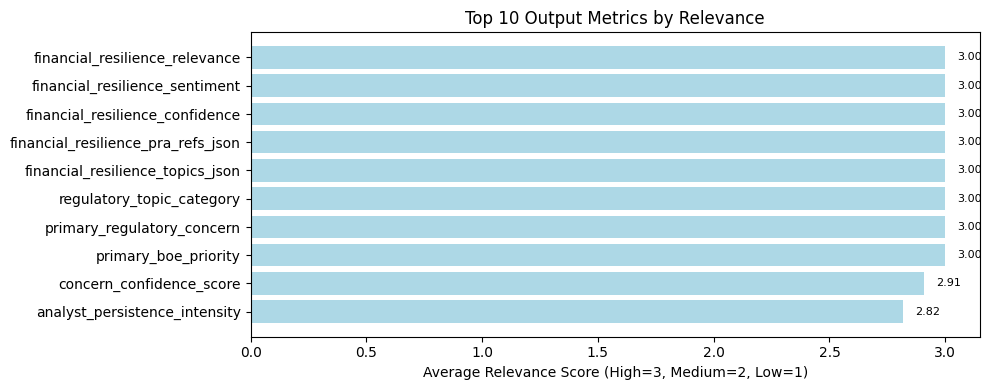

In [41]:
import matplotlib.pyplot as plt

# Join section and field for better readability
agg_df["label"] = agg_df['field']

# Select top N for better readability
top_n = 10
plot_df = agg_df.sort_values("avg_score", ascending=False).head(top_n)

plt.figure(figsize=(10, 4))
bars = plt.barh(plot_df["label"], plot_df["avg_score"], color="lightblue")
plt.xlabel("Average Relevance Score (High=3, Medium=2, Low=1)")
plt.title(f"Top {top_n} Output Metrics by Relevance")
plt.gca().invert_yaxis()

# Annotate values
for bar in bars:
    plt.text(bar.get_width() + 0.05, bar.get_y() + bar.get_height() / 2,
             f"{bar.get_width():.2f}", va="center", fontsize=8)

plt.tight_layout()
plt.show()

This block creates a horizontal bar chart to visualize the 5 least relevant output metrics based on their average relevance scores.

Steps:
- Selects the bottom n fields with the lowest `avg_score`
- Plots them as horizontal bars in light red
- Adds numerical score annotations next to each bar
- Inverts the y-axis so the least relevant metric appears at the top

This visualization helps identify which metrics consistently received low relevance ratings across evaluations.


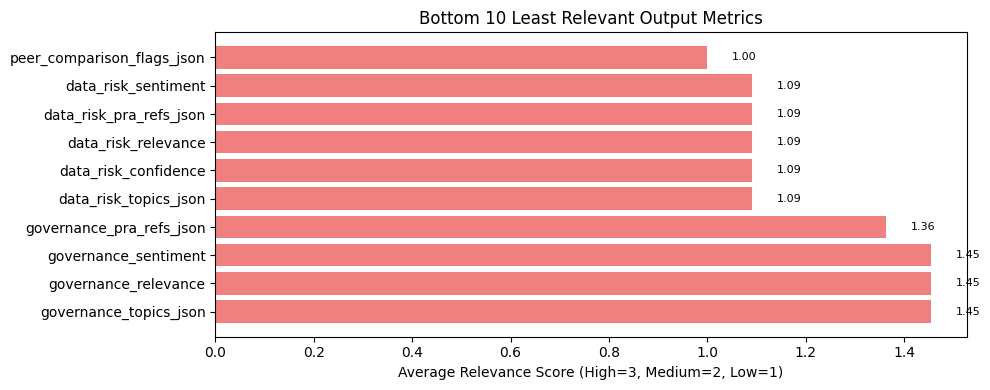

In [42]:
bottom_n = 10
bottom_df = agg_df.sort_values("avg_score", ascending=True).head(bottom_n)

plt.figure(figsize=(10, 4))
bars = plt.barh(bottom_df["label"], bottom_df["avg_score"], color="#f08080")  # light red

plt.xlabel("Average Relevance Score (High=3, Medium=2, Low=1)")
plt.title(f"Bottom {bottom_n} Least Relevant Output Metrics")
plt.gca().invert_yaxis()

# Annotate scores
for bar in bars:
    plt.text(bar.get_width() + 0.05, bar.get_y() + bar.get_height() / 2,
             f"{bar.get_width():.2f}", va="center", fontsize=8)

plt.tight_layout()
plt.show()

# JUSTIFICATION ABOUT RELEVANCE

This block identifies the most and least relevant output metrics for further analysis or focused visualization.

- `top_fields`: the top `n` fields with the highest average relevance scores
- `bottom_fields`: the bottom `n` fields with the lowest scores
- `target_fields`: a combined list of the top and bottom fields, typically used to filter or highlight key metrics in follow-up analysis


In [43]:
top_fields = agg_df.sort_values("avg_score", ascending=False).head(top_n)["field"].tolist()
bottom_fields = agg_df.sort_values("avg_score", ascending=True).head(bottom_n)["field"].tolist()

target_fields = top_fields + bottom_fields

This block generates concise summaries for the most and least relevant output metrics by synthesizing reviewer justifications using GPT-4o.

For each `field` in the top and bottom relevance groups:
- It collects all relevance justifications from the parsed evaluations
- Combines them into a bullet list
- Sends this list to an LLM along with a system prompt asking for a 2–3 sentence synthesis

The model is asked to highlight recurring themes, contradictions, weak evidence, or redundancy in how each metric was evaluated.

Each resulting summary is stored in the `summaries` dictionary keyed by the metric name. Errors are caught and flagged if they occur.


In [44]:
summaries = {}

for field in tqdm(target_fields):
    justifications = parsed_df[parsed_df["field"] == field]["justification"].tolist()

    # Combine justifications into a bullet list
    formatted_justs = "\n".join(f"- {j}" for j in justifications)

    system_prompt = (
        "You are a regulatory model evaluation expert. Your task is to critically analyze how a specific output metric "
        "was rated across multiple evaluations. The input includes multiple justifications from reviewers explaining "
        "why this metric was rated High, Medium, or Low in relevance. Your goal is to synthesize these justifications "
        "into a short but insightful explanation of the metric's actual value. Focus on patterns, judgment, and redundancy "
        "if applicable. Avoid repeating surface-level reasoning."
    )

    user_prompt = f"""
Below are relevance justifications for the metric '{field}':

{formatted_justs}

Please write 2–3 sentences that explain why this metric is considered {'highly' if field in top_15_fields else 'poorly'} relevant, based on the above.
If there are contradictory opinions or weak evidence, reflect that.
If the metric seems redundant or poorly defined, note that too.
"""
    try:
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": user_prompt}
            ],
            temperature=0.3,
            max_tokens=300
        )
        response_text = response.choices[0].message.content.strip()
        summaries[field] = response_text

    except Exception as e:
        print(f"❌ Error processing '{field}': {e}")
        summaries[field] = "ERROR"

100%|██████████| 20/20 [01:16<00:00,  3.81s/it]


This block displays the synthesized relevance summaries for the top and bottom metrics in a readable, styled HTML format.

- `display_justified_summaries()` takes a dictionary of metric summaries and a title, then renders each metric name followed by its corresponding explanation.
- The summaries are split into two groups: top 15 most relevant metrics and bottom 15 least relevant.
- Each group is shown under a clear section title using formatted HTML for visual clarity in Jupyter or Colab environments.


In [45]:
from IPython.display import display, HTML

def display_justified_summaries(summary_dict, title):
    display(HTML(f"<h2>{title}</h2>"))

    for field, summary in summary_dict.items():
        html = f"""
        <div style="margin-bottom: 20px;">
            <strong>{field}</strong>
            <div style="text-align: justify; margin-top: 5px;">{summary}</div>
        </div>
        """
        display(HTML(html))

# Split
top_summaries = {k: summaries[k] for k in list(summaries.keys())[:top_n]}
bottom_summaries = {k: summaries[k] for k in list(summaries.keys())[bottom_n:]}

# Display
display_justified_summaries(top_summaries, "Top {} Most Relevant Metrics".format(top_n))

In [46]:
display_justified_summaries(bottom_summaries, "Bottom {} Least Relevant Metrics".format(bottom_n))